This walkthrough shows my approach taken for the probability of collision pipeline between two satellites. The steps taken mostly from following those outlined in 'fundamentals of astrodynamics and applications', section 11.7. This intends to be a fullly general strategy for finding the time of closest approach and subsequently the probability of collision, given logs of the predictive ephemerises and covariances of each satellites. It is still a work in progress.

In [19]:
import numpy as np 
import matplotlib 
matplotlib.use('TkAgg',force=True)
import matplotlib.pyplot as plt 
import prob_collision as pc
import pickle
import os
file_dir = "/home/natsubuntu/Desktop/SysControl/estimation/CauchyCPU/CauchyEst_Nat/CauchyFriendly/scripts/swig/leo"
%matplotlib inline

Given the predicted trajectories of two satellites, we wish to find whether the two satellites come close enough to one another to warrant a probability of collision check. The last estimate of each satellite's filter (and its covariance) is taken and projected forwards using the satellite model, which generates a predictive trajectory (ephemeris) along with covariance information. These ephemeres can be used for the matter at hand.

As a preliminary, lets load in some data from propagating a satellite around the earth several times with GMAT:

In [20]:
# Load Data 
dir_path = file_dir + "/pylog/gmat7/pred/" + "mcdata_gausstrials_25_1709746486.pickle"
print("Reading MC Data From: ", dir_path)
with open(dir_path, "rb") as handle:
    mc_dic = pickle.load(handle)
# Obtain a trial
mc_trial = 0
xs,zs,ws,vs = mc_dic["sim_truth"][mc_trial]
xs_kf,Ps_kf = mc_dic["ekf_runs"][mc_trial]
dt = float(mc_dic["dt"])

Reading MC Data From:  /home/natsubuntu/Desktop/SysControl/estimation/CauchyCPU/CauchyEst_Nat/CauchyFriendly/scripts/swig/leo/pylog/gmat7/pred/mcdata_gausstrials_25_1709746486.pickle


The objective is to find local minimum distances between a primary satellite and a secondary satellite, and the times corresponding to these close approaches. Thus, we require an algorithm that smoothely fits the satellite's predictive ephemeres, filling in the gaps of the propagator. As I show, this can be accomplished pretty easily by chunking the predictive ephemeres into roughly quarter to half orbit-long sequences, and conducting polynomial fits over each chunk. This is heuristic of course, but seems to work very nicely. The motivation behind this approach is that it allows the predictive ephemerises of two satellite to be loaded and compared without matching time-stamping. For example, if the primary satellite logged its predictive ephemeris with 100 second time steps, but the secondary satellite logged its predictive ephemeris with 60 second time steps, the method here generalizes no problem. If both satellites log their predictive ephemerises with exact matching time stamps, i.e, each ephemeris point logged has a timestamp matching in the other satellite's ephemeris, the search for closest approach follows the routine presented here using cubic polynomials fitted to the four closest ephemeris points to the minimum (found by simply differencing the ephemerises). However, without matching time-stamping, one cannot simply difference the data points in the predicted ephemerises to find minimums.

Therefore, lets demonstrate the general approach. Here I use an 8-th order polynomial to fit quarter orbit chunks of each satellite very accurately. This will enable high fidelity detection of a possible collision plane later. The line of fit is parameterized for each dimension x,y,z as 
\begin{align}
    p(t) &= \theta_0 + \theta_1 t + \theta_2 t^2 + ... + \theta_f t^f = \theta^Tx(t), \quad t \in [0.0, 1.0]\\
    x(t) &= [1, t,t^2, \dots, t^f]\\
    \theta &= [\theta_0, \theta_1, \theta_2, \dots, \theta_f]
\end{align}
where $t$ is the time for the given set of points normalized to the unit time interval [0,1] and $f$ is the polynomial fit order. The poly fit function below takes the point set $Y\in\mathbb{R}^{N\times 3}$ of x,y,z points at times $T \in \mathbb{R}^N$, and returns a parameter matrix $\Theta\in \mathbb{R}^{f \times 3}$ as well as the design matrix $X\in\mathbb{R}^{N \times f}$, which holds the (normalized) times (row-wise) raised to the appropriate power (column-wise). That is, the first column of $\Theta$ holds the parameters for the x-axis, the second column hold y-axis parameters, and the third column holds the z-axis parameters.

Max Residual is:  9.168392361355332e-22


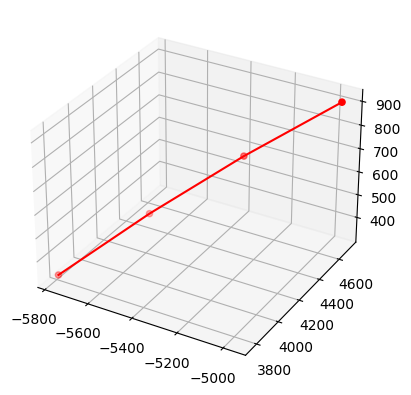

(4, 3)
(4, 4)


In [21]:
# Seems as though up to half orbit fits with 8th order poly is quick enough and simple
# Primary satellite ephemeris chunk
fit_order = 8
start_idx = 25
end_idx = 50
overlap = 5
Ys_primary = xs[start_idx:end_idx, 0:3]
Ts = np.arange(start_idx, end_idx) * dt
thetas_primary, Xs = pc.poly_fit(Ys_primary,Ts,fit_order, with_plot=True) # Max residual given in Kilometers
print(thetas_primary.shape)
print(Xs.shape)

To construct a simple trajectory for the secondary satellite, lets flip the later (back)half of the primary satellite's orbit and assign it to the secondary satellite. The fancy indexing on the first line below simply assures that the satellites will collide at exactly one of the ephemeris points, so we can do some error checking. Commenting this line out and replacing it with the second code line allows collisions between time propagation steps instead.

Max Residual is:  2.9473802318456846e-22
(4, 3)
(4, 4)


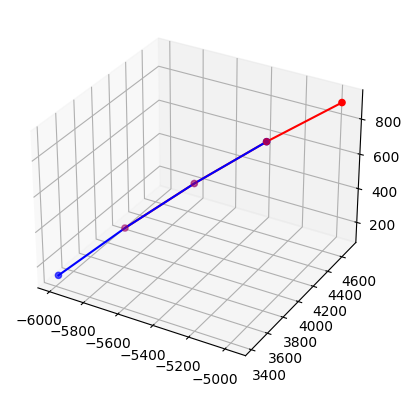

In [22]:

# Secondary satellite ephemeris chunk
Ys_secondary = xs[end_idx-1-2*(overlap-1):2*end_idx-1-2*(overlap-1)-start_idx, 0:3]
#Ys_secondary = xs[end_idx-overlap:2*end_idx-start_idx-overlap, 0:3]
Ys_secondary = np.flip(Ys_secondary, axis = 0)
thetas_secondary, _ = pc.poly_fit(Ys_secondary,Ts,fit_order, with_plot=False)
print(thetas_secondary.shape)
print(_.shape)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot the parametric lines 
Ypred_prim = Xs @ thetas_primary # primary
Ypred_sec = Xs @ thetas_secondary # secondary
ax.plot(Ypred_prim[:,0], Ypred_prim[:,1], Ypred_prim[:,2], color='r') # primary
ax.plot(Ypred_sec[:,0], Ypred_sec[:,1], Ypred_sec[:,2], color='b') # secondary
# Also overlay the (scattered) points that were fitted to on the plot
ax.scatter(Ys_primary[:,0], Ys_primary[:,1], Ys_primary[:,2], color='r') # primary
ax.scatter(Ys_secondary[:,0], Ys_secondary[:,1], Ys_secondary[:,2], color='b') # secondary
plt.show()

Note that when working with real data from two satellites, it will likely be the case that the reference points (which the polynomials are fitted to) may not be perfectly time synchronized. That is, the unit start time $t_p=0$ for the primary satellites fit needs to correspond exactly with the secondary satellites unit start time $t_s=0$. If this is not the case, we would need to manipulate the secondaries polynomial (i.e, $t_s$) so that both become time synched on the time interval $t\in[0,1]$. 

However, since we are dealing with predictive data, the easiest fix (to the above 'setback') is to propagate the secondary so that the starting times of both satellites are exact and subsequently, that they use equal lengthed propagation time steps. This easy time-sync solution may not always be possible, however.

Now, we can use the primary satellite vector polynomial $p_p(t) \in \mathbb{R}^3$  and the secondary satellite vector polynomial $p_s(t) \in \mathbb{R}^3$ to parameterize the relative position differences and rate differences between the two satellites as:
\begin{align}
    r_d(t) &= p_p(t) - p_s(t)\\
    \dot{r}_d &= \dot{p}_p(t) - \dot{p}_s(t)\\
    \ddot{r}_d &= \ddot{p}_p(t) - \ddot{p}_s(t)
\end{align}

Because the polynomials are smooth they can be analytically differentiated and this is a trivial operation:

In [23]:
# Differentiating polynomials and creating relative (rate) differences
dthetas_primary, dXs = pc.poly_deriv(thetas_primary, Xs)
ddthetas_primary, ddXs = pc.poly_deriv(dthetas_primary, dXs)
dthetas_secondary, _ = pc.poly_deriv(thetas_secondary, Xs)
ddthetas_secondary, _ = pc.poly_deriv(dthetas_secondary, dXs)
print("Xs shape: ", Xs.shape)
print("thetas_primiary (and secondary) shape: ", thetas_primary.shape)
print("dXs shape: ", dXs.shape)
print("ddXs shape: ", ddXs.shape)
print("dthetas_primary shape: ", dthetas_primary.shape)
print("dthetas_secondary shape: ", dthetas_secondary.shape)
print("ddthetas_primary shape: ", ddthetas_primary.shape)
print("ddthetas_secondary shape: ", ddthetas_secondary.shape)

Xs shape:  (4, 4)
thetas_primiary (and secondary) shape:  (4, 3)
dXs shape:  (4, 3)
ddXs shape:  (4, 2)
dthetas_primary shape:  (3, 3)
dthetas_secondary shape:  (3, 3)
ddthetas_primary shape:  (2, 3)
ddthetas_secondary shape:  (2, 3)


Lets use these polynomials to create the relative position differences and rate differences between the two satellites

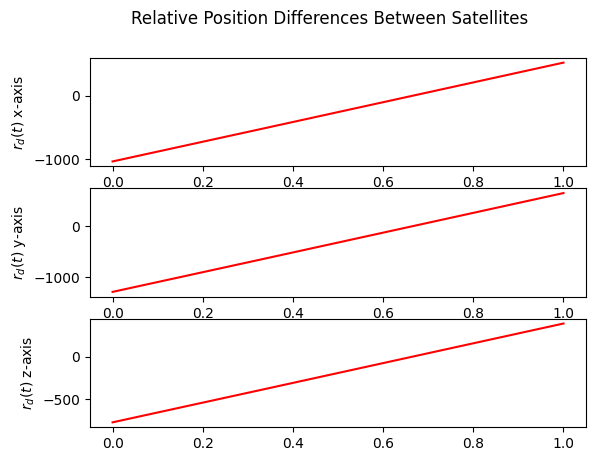

In [24]:
diff_thetas = thetas_secondary - thetas_primary
diff_dthetas = dthetas_secondary - dthetas_primary
diff_ddthetas = ddthetas_secondary - ddthetas_primary

diff_Ypred = Xs @ diff_thetas
diff_dYpred = dXs @ diff_dthetas
diff_ddYpred = ddXs @ diff_ddthetas
fig = plt.figure()
plt.suptitle("Relative Position Differences Between Satellites")
plt.subplot(3,1,1)
plt.plot(Xs[:,1], diff_Ypred[:,0], color='r', label="fit diff-x")
plt.ylabel(r"$r_d(t)$ x-axis")
#plt.plot(Xs[:,1], diff_dYpred[:,0], color='b', label="dfit diff-x")
#plt.plot(Xs[:,1], diff_ddYpred[:,0], color='g', label="ddfit diff-x")
plt.subplot(3,1,2)
plt.plot(Xs[:,1], diff_Ypred[:,1], color='r', label="fit diff-y")
plt.ylabel(r"$r_d(t)$ y-axis")
#plt.plot(Xs[:,1], diff_dYpred[:,1], color='b', label="dfit diff-y")
#plt.plot(Xs[:,1], diff_ddYpred[:,1], color='g', label="ddfit diff-y")
plt.subplot(3,1,3)
plt.plot(Xs[:,1], diff_Ypred[:,2], color='r', label="fit diff-z")
plt.ylabel(r"$r_d(t)$ z-axis")
#plt.plot(Xs[:,1], diff_dYpred[:,2], color='b', label="dfit diff-z")
#plt.plot(Xs[:,1], diff_ddYpred[:,2], color='g', label="ddfit diff-z")
plt.show()

Looks good, the differences of the polynomials cross zero for each axis. Lets now create the polynomial vector cost functions as follows:
\begin{align}
    f_d(t) &= r_d(t)^T r_d(t)\\
    \dot{f}_d(t) &= \dot{r}_d(t)^T r_d(t)\\
    \ddot{f}_d(t) &= 2(\ddot{r}_d(t)^T r_d(t) + \dot{r}_d(t)^T \dot{r}_d(t))
\end{align}

Doing this is no more complicated than a few for loops. The one thing here is that this will expand our polynomial to 16-th order, if using 8-th order polys to begin.

f_d shape:  (7,)
df_d shape:  (6,)
ddf_d shape:  (5,)


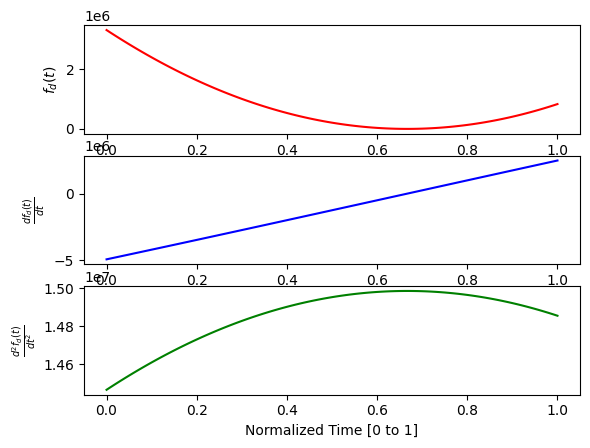

In [25]:
f_d = pc.poly_inner_prod(diff_thetas, diff_thetas)
df_d = pc.poly_inner_prod(diff_dthetas, diff_thetas)
ddf_d = 2*( pc.poly_inner_prod(diff_ddthetas, diff_thetas) + pc.poly_inner_prod(diff_dthetas, diff_dthetas) )
print("f_d shape: ", f_d.shape)
print("df_d shape: ", df_d.shape)
print("ddf_d shape: ", ddf_d.shape)

ts = np.linspace(0.0, 1.0, 101)
Xs_f_d = pc.poly_time_matrix(ts, poly_order_plus_1 = f_d.size)
Xs_df_d = pc.poly_time_matrix(ts, poly_order_plus_1 = df_d.size)
Xs_ddf_d = pc.poly_time_matrix(ts, poly_order_plus_1 = ddf_d.size)

# Form cost function values
fs = Xs_f_d @ f_d
dfs = Xs_df_d @ df_d
ddfs = Xs_ddf_d @ ddf_d

# Plot cost and its derivatives
plt.subplot(3,1,1)
plt.plot(ts, fs, 'r')
plt.ylabel(r"$f_d(t)$")
plt.subplot(3,1,2)
plt.plot(ts, dfs, 'b')
plt.ylabel(r"$\frac{df_d(t)}{dt}$")
plt.subplot(3,1,3)
plt.plot(ts, ddfs, 'g')
plt.ylabel(r"$\frac{d^2f_d(t)}{dt^2}$")
plt.xlabel("Normalized Time [0 to 1]")
plt.show()


As basic calculus suggests, the extrema of $f_d(t)$ are found where $\frac{df_d(t)}{dt}$=0, and therefore we simply need to find the real roots of $\frac{df_d(t)}{dt}$=0 on the interval [0,1], only keeping the roots where $\frac{d^2f_d(t)}{dt^2}$>0. This is again very simple:

In [26]:
# Find poly-roots of df_d (this function requires the poly ordering in opposite direction)
df_d_roots = np.roots( np.flip(df_d) )
print("All roots:\n", df_d_roots)
# First filter these for only the roots which are non-complex
df_d_roots = df_d_roots[ np.isclose( np.imag(df_d_roots), 0, 0, 2.2e-16 ) ]
print("Non complex roots:\n", df_d_roots)
df_d_roots = np.real(df_d_roots)
# Now filter roots to interval [0,1]
df_d_roots = df_d_roots[ (df_d_roots >=-1e-6) * (df_d_roots <= (1+1e-6)) ]
print("Roots in [0,1]:\n", df_d_roots)
# Now only keep roots where ddf_d are positive:
Xs_roots = pc.poly_time_matrix(df_d_roots, poly_order_plus_1 = ddf_d.size)
df_d_roots = df_d_roots[ Xs_roots @ ddf_d > 0 ]
print("Roots at local minimum:\n", df_d_roots)
# All thats left is the one root of interest

All roots:
 [ 13.02215591 -11.68882257   7.80027335  -6.46694002   0.66666667]
Non complex roots:
 [ 13.02215591 -11.68882257   7.80027335  -6.46694002   0.66666667]
Roots in [0,1]:
 [0.66666667]
Roots at local minimum:
 [0.66666667]


Now lets convert this time instant back from the unit [0,1] time to regular seconds

In [27]:
#print(Xs[:,1])
#print(Ts)
collision_time = df_d_roots * (Ts[-1] - Ts[0]) + Ts[0]
print("Collision time in seconds 't_c': ", collision_time)
X_ct = pc.poly_time_matrix(df_d_roots, thetas_primary.shape[0])
pp = X_ct @ thetas_primary
ps = X_ct @ thetas_secondary
print("Estimated Primary Satellite Position at Collision (km): ", pp)
print("Estimated Secondary Satellite Position at Collision (km): ", ps)
print("Estimation Diff in meters: ", 1000*np.linalg.norm(ps - pp) )
idx = np.argmin(np.abs(Ts-collision_time))
print("True Primary/secondary Satellite Position at Collision: (km)", Ys_primary[idx])
print("Primary: True Error in meters: ", 1000*np.linalg.norm(Ys_primary[idx] - pp) )
print("Secondary: True Error in meters: ", 1000*np.linalg.norm(Ys_secondary[idx] - ps) )


Collision time in seconds 't_c':  [1620.]
Estimated Primary Satellite Position at Collision (km):  [[-5527.24773725  4100.67861824   525.87869899]]
Estimated Secondary Satellite Position at Collision (km):  [[-5527.24773725  4100.67861824   525.87869899]]
Estimation Diff in meters:  2.919251318545145e-08
True Primary/secondary Satellite Position at Collision: (km) [-5527.24773725  4100.67861824   525.87869899]
Primary: True Error in meters:  2.2755550168216003e-08
Secondary: True Error in meters:  7.000746481180909e-09


The result is good to a few centimeters, and works well when the time of closest approach is between ephemeris data points. This procedure can be reiterated in its entirety for long orbital stretches, giving a completely automatic and general closest approach pipeline. Now we have our time of closest approach $t_c$. To make the above procedure even more robust to any numerical error, the procedure could 

1.) Use the propagator, starting at the ephemeris point right before $t_c$ is hit, i.e, $x(t_k)$, and propagate $\Delta = t_c - t_k$ seconds from $x(t_k)$ to $x(t_c)$ and check the position difference against the solution here.

2.) Fit the predictive ephemeres using cubic splines between succesive four data points of each satellite's predictive ephemeris, using the above procedure for each grouping of four. However, this process may add slight complexity and additional interpreter overhead in a language like python/matlab (but would likely be rip-roaring fast in C, especially if parallelized), but is a fairly trivial extension of whats presented here. If the predictive ephemerises have equal time-stamps, one can fit splines between each data point, given derivative information of the point set is present. This is shown in the second notebook. See Vallardo.

Now, what remains is to decide if its actually worth computing a probability of collision for the time of closest approach found. To do so, we choose a nominal threshold $R_c$ and test if $||p_p(t_c) - p_s(t_c)||_2 \leq R_c$, where $R_c$ could be 1km. If $||p_p(t_c) - p_s(t_c)||_2 > R_c$, there is likely no need to check probability of collision. On the other extreme, if $||p_p(t_c) - p_s(t_c)||_2 \leq R_s + R_p$, where $R_p$ is the effective radius of the primary satellite, and $R_s$ is the effective radius of the secondary satellite, there is no need to check for a probability: collision is fairly imminent, and you should manuever.

As Vallardo suggests, if $R_s + R_p \leq ||p_p(t_c) - p_s(t_c)||_2 \leq R_c$, a probability of collision should be computed. He suggests the following steps:

1.) Place the primary satellite at the time and position of closest approach computed. 

2.) Sum the covariances and assign it to the primary satellite. Transform the covariance into relative along, cross, radial track error coordinates. 

3.) Define an n-sigma shell which corresponds to the probability region we'd like to test (i.e, 99.999%).

4.) The transformed covariance can now be projected onto the "encounter plane", which corresponds to the relative cross and radial track error covariances. Along track covariance only contributes to the time interval to be integrated over during the probability of collision computation.

5.) Find the entry and exit times the secondary will have w.r.t the primaries n-sigma shell.

5.) Compute probability of collision over this time interval. This is disscused in detail in the accompanying latex note.